In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
''' defining functions used later within the notebook '''

def str_to_percent(word):
    str_num = re.findall("\d+\.\d+", word)
    if not str_num:
        str_num = re.findall("\d+", word)
    return float(str_num[0]) / 100

def map_hours(df):
    hour_map = {'Not at all': 0, 'Less than 1 hour': 1, '1-2 hours': 2, '3 or more hours': 3}
    df = df.applymap(lambda x: hour_map.get(x) if x in hour_map else x)
    return df

In [3]:
df = pd.read_csv("../data/maps-synthetic-data-v1.1.csv")

In [15]:
df2 = df[['X', 'dep_band_15', 'dep_band_10', 'dep_band_13', 'dep_band_07', 'dep_score', 'comp_week', 'comp_wend', 'tv_week', 'tv_wend']].copy().dropna()

In [16]:
# doesn't work
# dep_bands = ['dep_band_15', 'dep_band_10', 'dep_band_13', 'dep_band_07']
# df2[dep_bands] = df2[dep_bands].apply(str_to_percent)

# Doing each column individually then
df2['dep_band_15'] = df2['dep_band_15'].apply(str_to_percent)
df2['dep_band_13'] = df2['dep_band_13'].apply(str_to_percent)
df2['dep_band_10'] = df2['dep_band_10'].apply(str_to_percent)
df2['dep_band_07'] = df2['dep_band_07'].apply(str_to_percent)

In [17]:
df2 = map_hours(df2)
df2

,X,dep_band_15,dep_band_10,dep_band_13,dep_band_07,dep_score,comp_week,comp_wend,tv_week,tv_wend
0,1,0.005,0.005,0.005,0.005,0.0,2,2,2,2
5,6,0.005,0.001,0.150,0.001,0.0,2,1,2,3
8,9,0.150,0.001,0.001,0.001,0.0,3,3,2,2
33,34,0.150,0.001,0.001,0.005,2.0,2,2,1,2
35,36,0.005,0.150,0.005,0.001,0.0,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...
13671,13672,0.005,0.700,0.150,0.005,0.0,3,3,3,3
13694,13695,0.001,0.001,0.001,0.001,0.0,3,3,1,2
13716,13717,0.005,0.005,0.005,0.005,0.0,3,3,2,3
13720,13721,0.005,0.150,0.001,0.005,0.0,2,3,1,2


In [20]:
df2['screentime'] = df2[['comp_wend', 'comp_week', 'tv_week', 'tv_wend']].sum(axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

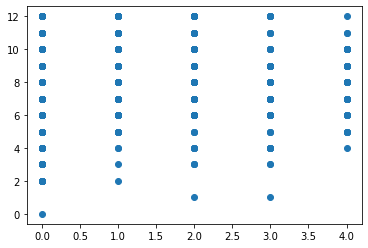

In [24]:
x = df2['dep_score']
y = df2['screentime']
plt.scatter(x, y)
plt.show

[Look into removing columns that aren't useful / are duplicated?

In [9]:
# Unnamed is the same as column X - flag is the same throughout the dataset
del df['Unnamed: 0']
del df['flag']
# Do we need the column X?


KeyError: 'Unnamed: 0'

How do we want to deal with NAN values? Looking into just filling them with 0/False

In [5]:
df = df.fillna(0)

Lot of string values within columns, looking into mapping them to integer values which can be better dealt with

In [6]:
map_list = []

# create a bunch of dictionaries to map value too
'''
    Need to discuss these bindings, some columns use similar but use different generalisations
    Some use '1 or more hours' and some use 'Less than 3 hours'
    Do we want to label these differently?
'''
hours_map = {'Not at all': 0, 'Less than 1 hour': 0, '1-2 hours': 0,
            '3 or more hours': 1, '1 or more hours': 1, 'Less than 3 hours': 0}

purchase_map = {'In her/his room': 1, 'Have in house': 2, 'Bought in last 6 months': 3, 'Intend to buy': 4}
occurance_map = {'Not at all': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3, 'sometimes': 1, 'often': 2}
television_map = {'Don\'t have a T.V.': 0, 'No hardly ever': 1,
                  'Yes Some Days': 1, 'Yes Every Days': 1, 'Any at all': 1}

yes_no_map = {'No': 0, 'Yes': 1}
sex_map = {'Male': 0, 'Female': 1}
# 0 = first born, 1 = other birth
birth_map = {'A': 0, 'B': 1}

# add all the maps to the same list to iterate over
map_list.extend([hours_map, yes_no_map, purchase_map, occurance_map, television_map, sex_map, birth_map])

In [7]:
for mapping in map_list:
    df = df.applymap(lambda x: mapping.get(x) if x in mapping else x)

In [21]:
df

,X,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
0,1,0,3.0,30,59.294132,181.602831,107.0,0,0,1,...,0.0,1,1,2,0,"Yes, Some Days",Other,"Yes, Every Day",1,0
1,2,0,9.0,26,0.000000,0.000000,85.0,0,0,0,...,0.0,0,0,0,0,0,0,0,1,1
2,3,0,3.0,24,0.000000,0.000000,0.0,0,0,0,...,0.0,0,0,0,0,"Yes, Some Days","Yes, Every Day",Other,0,0
3,4,0,0.0,22,49.812426,160.224186,0.0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
4,5,0,8.0,31,62.270030,191.703227,132.0,1,0,0,...,0.0,0,0,2,0,"Yes, Some Days","Yes, Every Day","Yes, Every Day",1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,13730,0,13.0,27,0.000000,0.000000,0.0,0,0,0,...,0.0,0,0,0,0,"Yes, Every Day","Yes, Every Day","Yes, Every Day",1,0
13730,13731,0,6.0,29,0.000000,0.000000,0.0,0,0,0,...,0.0,0,0,0,0,"Yes, Every Day",Other,Other,0,0
13731,13732,0,21.0,37,58.075832,169.235565,108.0,0,0,1,...,0.0,0,0,2,0,Other,Other,Other,0,0
13732,13733,0,10.0,30,0.000000,0.000000,103.0,0,0,1,...,0.0,1,0,1,0,"Yes, Some Days",Other,"Yes, Every Day",0,0


In [24]:
df.iloc[0]['dep_band_07']

'~0.5%'

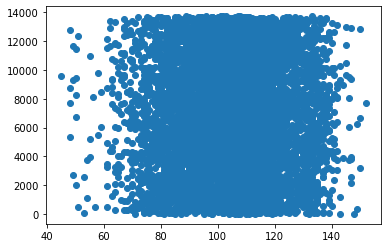

In [30]:
x = df['iq'].to_numpy()
y = df['X'].to_numpy()
plt.scatter(x,y)
plt.show()